# PyTorch Custom Datasets
#coding/python #coding/deeplearning

- [YT: Learn PyTorch for Deep Learing](https://www.youtube.com/watch?v=Z_ikDlimN6A&t=71017s)
- [LearnPyTorch.io](https://www.learnpytorch.io/03_pytorch_computer_vision/)

## Quick-guide
### Creating a `Dataset`
- import from `torchvision.datasets` etc (for this example)
- function/constructor: `datasets.ImageFolder(src, transform, target_transform)`
- return type: `<class 'torchvision.datasets.folder.ImageFolder'>`

A dataset is a collection (or list?) of "Data"
- getting item: `dataset[index]`
- item type: `<class 'torch.Tensor'>`

### Creating a `DataLoader`
- import from `torch.utils.data` import `DataLoader`
- function/constructor: `DataLoader(Dataset, batch_size, num_workers, shuffle)`
- return type: `<class 'torch.utils.data.dataloader.DataLoader'>`

A DataLoader is an iterable chunk of `Dataset`
- getting sub-dataset: `next(iter(dataloader))` ??

### Creating a *custom* `Dataset` class
- Subclass `torch.utils.data.Dataset`

## 01. Introduction to custom datasets
- preprocessing datasets to be used in PyTorch

### PyTorch Domain Libraries
Pytorch has existing and customizable **data loading functionns** that can be used depending on the data you are working on:
- TorchVision
- TorchAudio
- TorchText
- TorchRec

| Problem Space | Datasets |
| --- | --- |
| Vision | `torchvision.datasets` |
| Text | `torchtext.datasets` |
| Audio | `torchaudio.datasets` |
| Recom System | `torchrec.datasets` |
| **Bonus** | `TorchData` |

### What we're going to build
FoodVision Mini

### Outline
- getting custom dataset
- prepare and visualize data
- transform data for use with a model
- loading custom data (with pre-built functions and custom functions)
- comparing models with/without data augmentation
- making predictions on custom data

###

In [2]:
# Import dependencies, check version
import torch
from torch import nn

torch.__version__

'2.0.0+cu117'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 02. Downloading a custom dataset of pizza, steak and sushi images

Sample dataset will be from Food101 dataset
- Original: 101 classes, 750 train img, 250 test img
- Reduced: 3 classes, 75 train img, 25 test img

### STEP 01: GET DATA
Downloading dataset from GitHub

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prep
if image_path.is_dir():
    print(f"{image_path} dir already exists.")
else:
    print(f"{image_path} dir does not exist, creating one") 
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi dir already exists.
Unzipping pizza, steak, sushi data...


## 03. Becoming one with the data

### Standard image classification data format
```
pizza_steak_sushi/  # overall dataset folder
  train/            # training images
    pizza/          # class name as folder name
      img1
      img2
    steak/
      img3
      img4
  test/             # testing images
    pizza/
    steak/
```

There are existing DataLoaders in pytorch documentation (Docs>Datasets>...) which describes the file structure of data which will be loaded.

### STEP 02: DATA PREPARATION & EXPLORATION

In [5]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames, in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing and image
1. Get all image paths
2. Pick random image using `random.choice()`
3. Get image class name using `pathlib.Path.parent.stem`
4. open image using `PIL`
5. show image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/618348.jpg
Image class: pizza
h: 512
w: 512


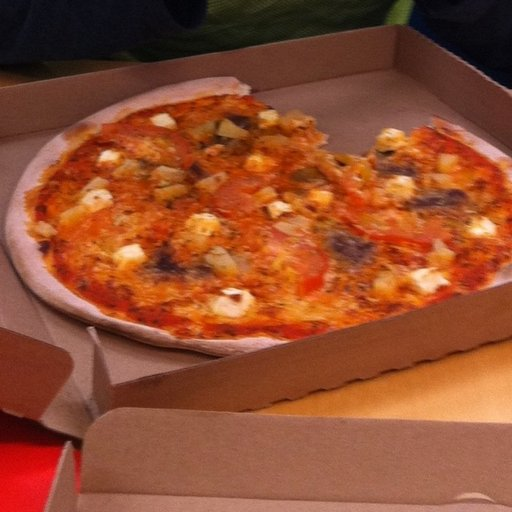

In [7]:
import random
from PIL import Image

# 0. Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # What is glob?

# 2. Pick a random image
random_image_path = random.choice(image_path_list) # pass in a list

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"h: {img.height}")
print(f"w: {img.width}")
img


#### 2.2 Visualize using `matplotlib`

(-0.5, 511.5, 511.5, -0.5)

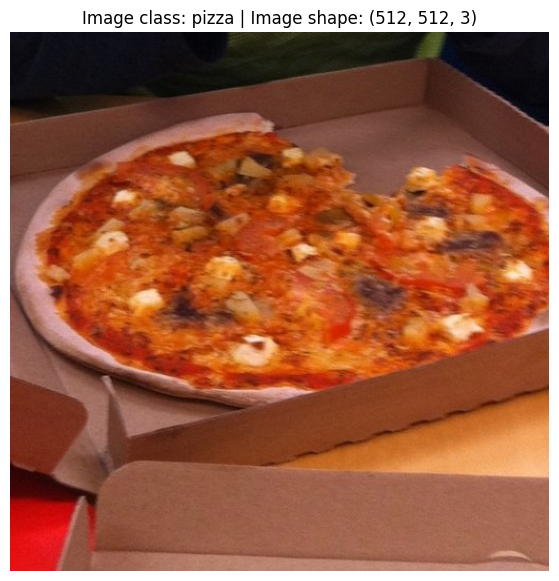

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)


## 04. Turning images into tensors



### STEP 03: TRANSFORMING DATA
For data to be used with PyTorch:
1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` (call it **Dataset**)
3. Turn it into a `torch.utils.data.DataLoader` (call it **DataLoader**)

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=74323s
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**Transform parameter**
callback function that performs a transform?

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transform data with `torchvisions.transforms`

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write a transform 
data_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=(64,64)),
    # Flip images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensor
    transforms.ToTensor()
])

print(img)
print(data_transform(img).shape)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FC7AA3F34F0>
torch.Size([3, 64, 64])


**Visualize transforms**

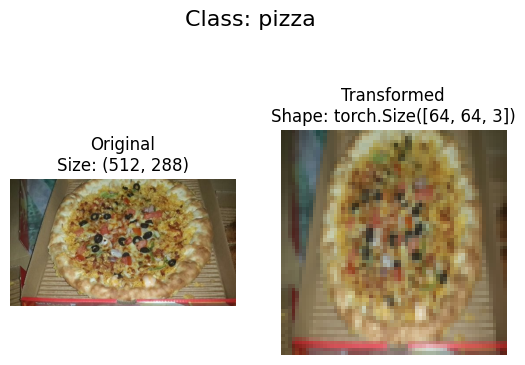

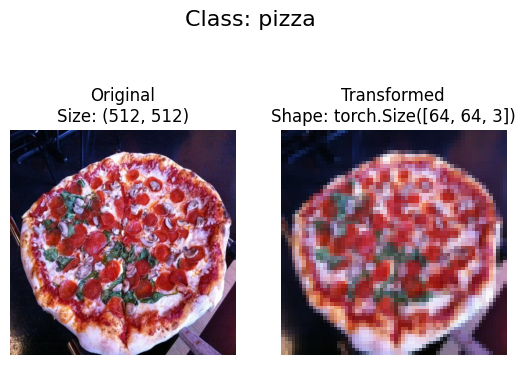

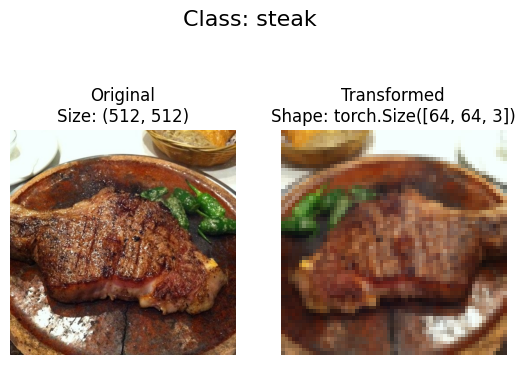

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Selects random images from a path of images and load/transform
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3, seed=42)


### STEP 04A: LOADING IMAGE DATA using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [39]:
# Turn all image data into tensors
# check ImageFolder documentation, how classes are determined by the method
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform the data
                                  target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"{type(train_data)}, {type(test_data)}")
train_data, test_data

<class 'torchvision.datasets.folder.ImageFolder'>, <class 'torchvision.datasets.folder.ImageFolder'>


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
print(class_names)

class_dict = train_data.class_to_idx
print(class_dict)

print(f"{len(train_data)}, {len(test_data)}")

print(train_data.samples[0])

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225, 75
('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)


In [40]:
# Get item property
# Index on train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n {img}")
print(f"type: {type(img)}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")

print(f"Image label: {label}")
print(class_names[label])

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [cc, h, w]
Image permute: torch.Size([64, 64, 3]) -> [h, w, cc]


Text(0.5, 1.0, 'pizza')

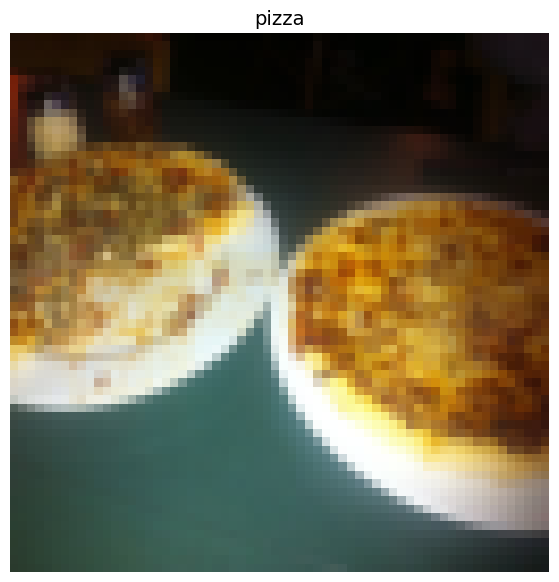

In [23]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [cc, h, w]")
print(f"Image permute: {img_permute.shape} -> [h, w, cc]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 05. Creating image DataLoaders


#### 4A.1 Turn loaded images into `DataLoaders`
Turns `Datasets` into iterables and we can customize `batch_size` so the model can process by batch (so as not to overload the machine)

In [43]:
# Turn train and test dataset into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"{type(train_dataloader)}, {type(test_dataloader)}")
train_dataloader, test_dataloader

print(iter(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>, <class 'torch.utils.data.dataloader.DataLoader'>


In [29]:
# Explore DataLoaders
print(f"{len(train_dataloader)}, {len(test_dataloader)}")

img, label = next(iter(train_dataloader))

# Batch size will now be 1
print(f"Image shape: {img.shape} -> [batch_size, color_channels, h, w]")
print(f"Label shape: {label.shape}")

8, 3
Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, h, w]
Label shape: torch.Size([32])


## 06. Creating a custom dataset class (overview)
Used for cases when datasets are not applicable to pre-existing classes


### STEP 04B: LOADING IMAGE DATA WITH CUSTOM `Dataset`
1. Want to be able to load images from file
2. Get class names from Dataset
3. Get classes as dict from Dataset

We build on top of the base `torch.utils.data.Dataset` class for custom classes.

**PROS**
- create `Dataset` from almost anything
- not limited to PyTorch pre-built `Dataset` functions

**CONS**
- not always works
- a custom `Dataset` needs to have more code written

All custom datasets in torch often subclass [this](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In [30]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [31]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 04B.1 Create a helper function to get class names

- get class names using `os.scandir()` to traverse a target diectory (ideally in standard image classification format)
- raise an error if the class names aren't found ()
- turn class names into a dict and list and return them

In [32]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [34]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory"""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}... Please check file structure.")
    
    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 07. Writing a custom dataset class from scratch


#### 04B.2 Create a custom `Dataset` to replicate `ImageFolder`

- all datasets that represent a map from keys to data samples should subclass `torch.utils.data.Dataset`
- all subclass should overwrite `__getitem__()`, supporting fetching a data sample for a given key

Procedure
1. subclass `torch.utils.data.Dataset`
2. int subclass with a target directory + transform
3. create several attributes
  - paths: path of images
  - transform - transform we'd like to use
  - classes - list of the target class
  - class_to_idx: dict of target class mapped to integer labels
4. Create function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` function to return the length of the dataset
6. Overwrite the `__getitem__()` method to return given sample when passed an index

In [36]:
# 0. Import modules
from torch.utils.data import Dataset

# 1. Subclass
class ImageFolderCustom(Dataset):
    # 2. Initialise the custom dataset
    def __init__(self, target_dir: str, transform=None):
        # 3. Crete class attributes
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        # replicates `img, label = train_data[0]`
        "Returns one sample of data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects a path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return (X', y)
        else:
            return img, class_idx # return (X, y)

In [44]:
## Instantiating the custom class

# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# Create an ImageFolderCustom instance
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fc79f6ebee0>,
 <__main__.ImageFolderCustom at 0x7fc79f6ebc70>)

In [47]:
## Inspect the new instance
print(f"{len(train_data)}, {len(test_data)}")
print(f"{len(train_data_custom)}, {len(test_data_custom)}")

print(train_data_custom.classes)
print(train_data_custom.class_to_idx)

# Check for equality
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

225, 75
225, 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
True
True


#### 04B.3 Create a function to display random images
1. Take a `Dataset`
2. cap number of images to 10
3. set random seed for reproducibility
4. get list of random sample indexes from target dtaset
5. setup matplotlib plot
6. loop through random sample images, plot with matplotlib
7. make sure dimensions line up with matplotlib

In [49]:
# 1. Create function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. ADjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
    
    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n) #returns list

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) #[cc, h ,w] -> [h, w, cc]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

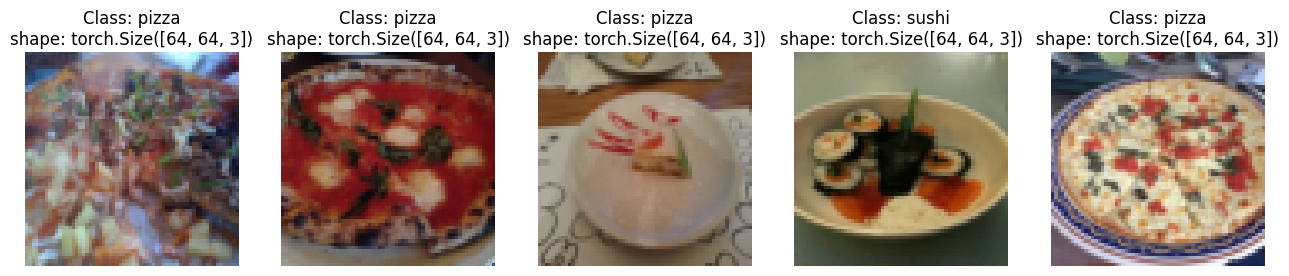

In [50]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

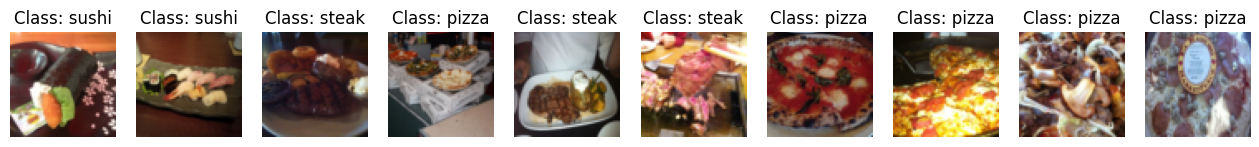

In [52]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

## 08. Turning custom datasets into DataLoaders


#### 04B.4 Turn custom loaded images into `DataLoader`

In [53]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fc79f638340>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc79f6385e0>)

In [54]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 09. Data augmentation
A technique to used to increase the amount of data by slightly modifying copies of already existing data.
- Adds diversity
- Acts as regulizer
- Reduces overfitting

**Which data augment should you use?**
*Try out yourself!*

### STEP 05: OTHER FORMS OF TRANSFORMS
Try out a particular type of data agumentation used to train PyTorch vision models to state-of-the-art levels

[PosixPath('data/pizza_steak_sushi/train/pizza/2190018.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/2228322.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/1899785.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/29417.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/2330965.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/1008844.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/1044789.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'), PosixPath('data/pizza_steak_sushi/train/pizza/3269634.jpg')]


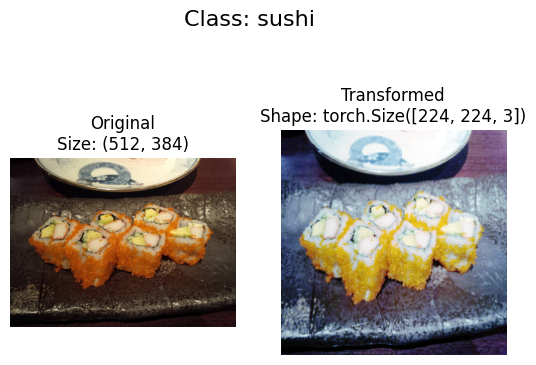

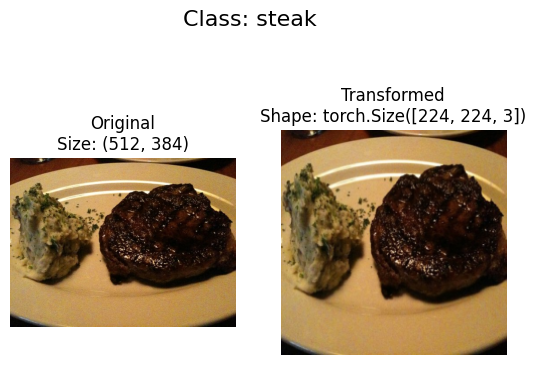

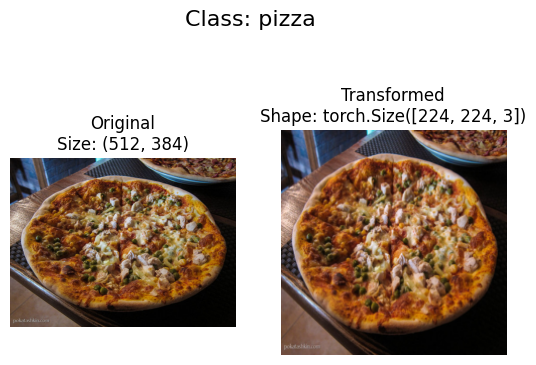

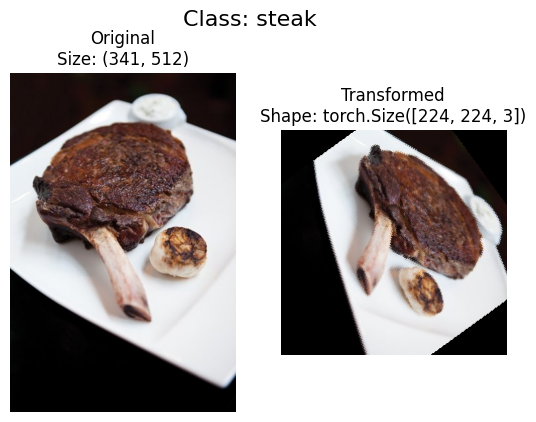

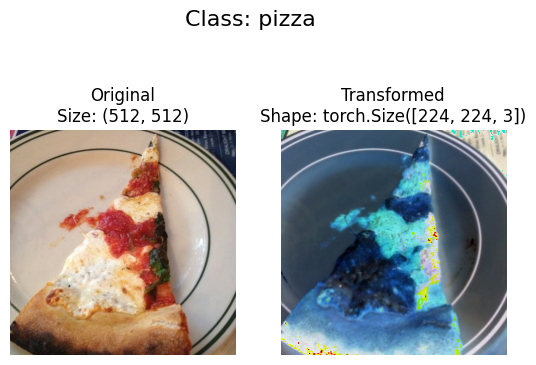

In [58]:
# Trivial Augment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()    
])

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:10])

# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=5, seed=None,
)

## 10. Building a baseline model


### STEP 06: Model_0: TinyVGG without data augmentation
Replicate TinyVGG architecture based from CNN Explainer website

#### 06.1 Creating transforms and loading data for Model 0

In [63]:
## Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn Dataset into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

#### 06.2 Create TinyVGG Model Class

In [78]:
## Create TinyVGG Class
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self, input_shape:int, 
                 hidden_units:int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self,x):
        # x = self.conv_block_1(x)
        # print(x.shape) # check shape for classifier in_features
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # alternative, with benefits from operator fusion

In [70]:
# Create a model instance
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### 06.3 Try a forward pass for a single image

In [71]:
# Get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
print(f"{image_batch.shape}, {label_batch.shape}")

model_0(image_batch)

# NOTE:
# based on the print results, classifier in_features should be `hidden_units*13*13`

torch.Size([32, 3, 64, 64]), torch.Size([32])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7905e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7978e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2783e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## 11. Getting a summary of our model with torchinfo


#### 06.4 User `torchinfo` to get idea of the shapes going through the model

In [73]:
try: 
  import torchinfo
except:
  %pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])



torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 12. Creating training and testing loop functions


#### 06.5 Create train and test loop functions

- `train_step()`: takes in a model and dataloader and trains it
- `test_step()`: takes in a model and dataloader and evaluates it

In [74]:
# Create a `train_step()`
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0 
    
    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [76]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put the model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0 

    # Turn on the inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calcualte the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc


#### 06.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [81]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model params, optim, 
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    
    # 2. Create empty results dict
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print status
        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


#### 06.7 Train and Evaluate model_0

In [82]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target image
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total Time: {end_time-start_time:.3f}")

 20%|██        | 1/5 [00:01<00:05,  1.41s/it]

Epoch: 0, Train Loss: 1.1063, Train Acc: 0.3047, Test Loss: 1.0983, Test Acc: 0.3011


 40%|████      | 2/5 [00:02<00:04,  1.38s/it]

Epoch: 1, Train Loss: 1.0998, Train Acc: 0.3281, Test Loss: 1.0697, Test Acc: 0.5417


 60%|██████    | 3/5 [00:04<00:02,  1.36s/it]

Epoch: 2, Train Loss: 1.0869, Train Acc: 0.4883, Test Loss: 1.0808, Test Acc: 0.4924


 80%|████████  | 4/5 [00:05<00:01,  1.36s/it]

Epoch: 3, Train Loss: 1.0843, Train Acc: 0.3984, Test Loss: 1.0607, Test Acc: 0.5833


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

Epoch: 4, Train Loss: 1.0662, Train Acc: 0.4141, Test Loss: 1.0656, Test Acc: 0.5644
Total Time: 6.605


## 13. Plotting model_0 loss curves


#### 06.8 Plot the loss curves of `model_0`
A **loss curve** is a way of tracking your model's progress over time.

Reference: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [84]:
# Get the `model_0_results` keys
model_0_results.keys()

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dict"""
    # Get the loss values of the results dict
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the acc values
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


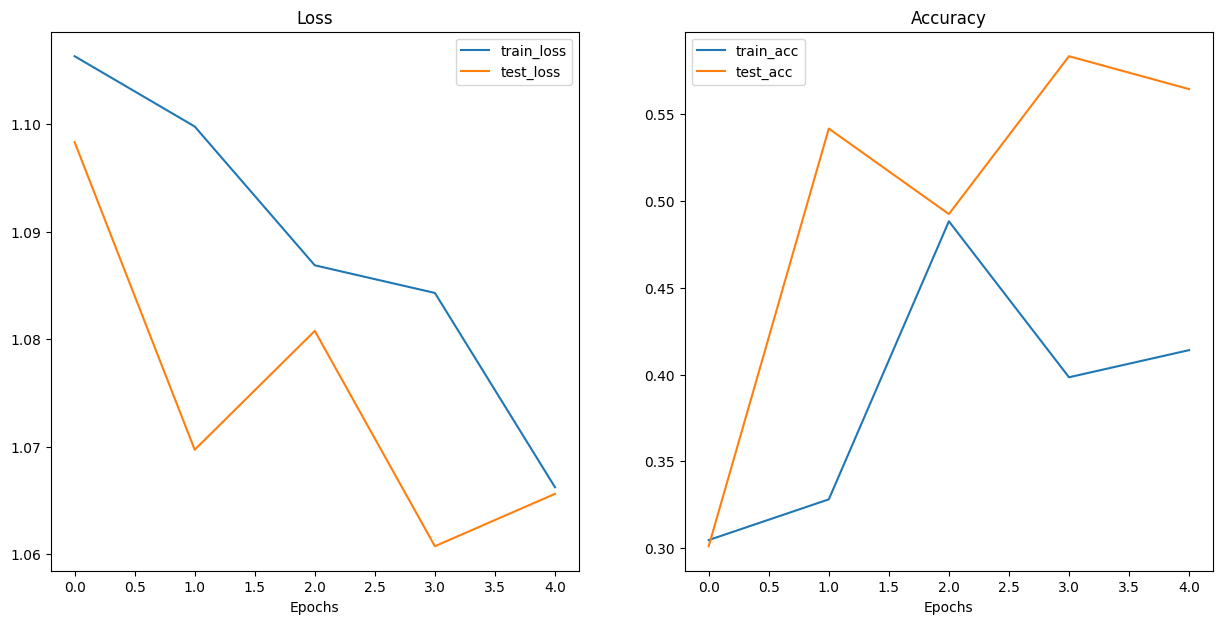

In [85]:
plot_loss_curves(model_0_results)

## 14. Overfitting and underfitting


### STEP 07: IDEAL LOSS CURVE

Loss curve - one of the most helpful ways to troubleshoot a model

REFERENCE: https://developers.google.com/machine-learning/testing-debugging/?sjid=16185066418821464427-AP

**Underfitting**: test & train curves are consistent, but high loss
**Overfitting**: test loss is higher than train loss, signifying much better training

**Dealing with Overfitting**
https://youtu.be/Z_ikDlimN6A?t=86692
- get more data
- data augmentation
- better data
- transfer learning: use pre-trained models
- simplifying model
- use learning rate decay: smaller steps at the end
- use early stopping: stop at an epoch before test & train curves diverge

**Dealing with Underfitting**
https://youtu.be/Z_ikDlimN6A?t=87023
- add more layers
- tweak the learning rate
- train for longer
- use transfer learning
- use less regularization


## 15. Plotting model_1 loss curves


### STEP 08: TinyVGG with Data Augmentation
Same model with data augmentation

#### 08.1 Create transform with data augmentation

In [86]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#### 08.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [87]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_agumented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)
                                            

In [88]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_agumented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

#### 08.3 Construct and train model_1
Same model architecture, but with training data augmentation

In [90]:
# Create model_1
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_agumented.classes)).to(device)

In [91]:
# Train model_1
torch.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss_fn and optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total Time: {end_time-start_time:.3f}")                        

 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

Epoch: 0, Train Loss: 1.1045, Train Acc: 0.2500, Test Loss: 1.0980, Test Acc: 0.3047


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

Epoch: 1, Train Loss: 1.0760, Train Acc: 0.4258, Test Loss: 1.1122, Test Acc: 0.3047


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

Epoch: 2, Train Loss: 1.0730, Train Acc: 0.4258, Test Loss: 1.1306, Test Acc: 0.3047


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

Epoch: 3, Train Loss: 1.1221, Train Acc: 0.3047, Test Loss: 1.1113, Test Acc: 0.3047


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

Epoch: 4, Train Loss: 1.0737, Train Acc: 0.4648, Test Loss: 1.1009, Test Acc: 0.4375
Total Time: 12.057


## 16. Plotting all the loss curves


#### 08.4 Plot the loss curves of model_1

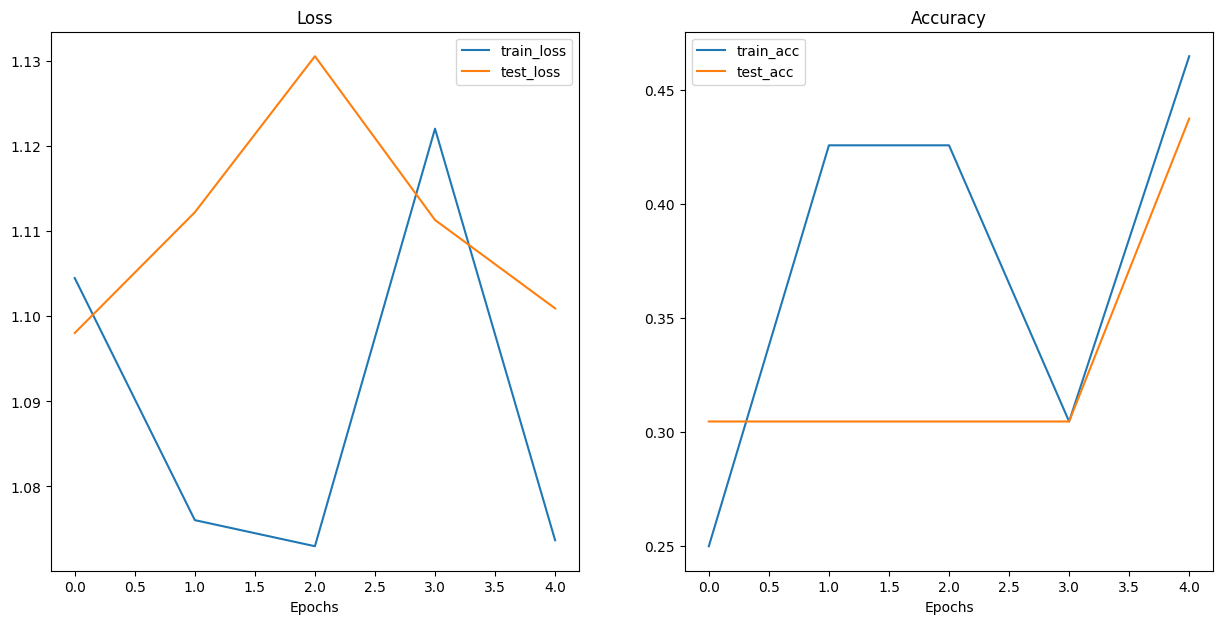

In [92]:
plot_loss_curves(model_1_results)

### STEP 09: COMPARE MODEL RESULTS
How to compare results
1. Hard coding
2. PyTorch + Tensorboard- 
3. Weights & Biases - 
4. MLFlow - 

In [93]:
import pandas as pd 
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098322,0.301136
1,1.099779,0.328125,1.069703,0.541667
2,1.086862,0.488281,1.080761,0.492424
3,1.084293,0.398438,1.060724,0.583333
4,1.066216,0.414062,1.065597,0.564394


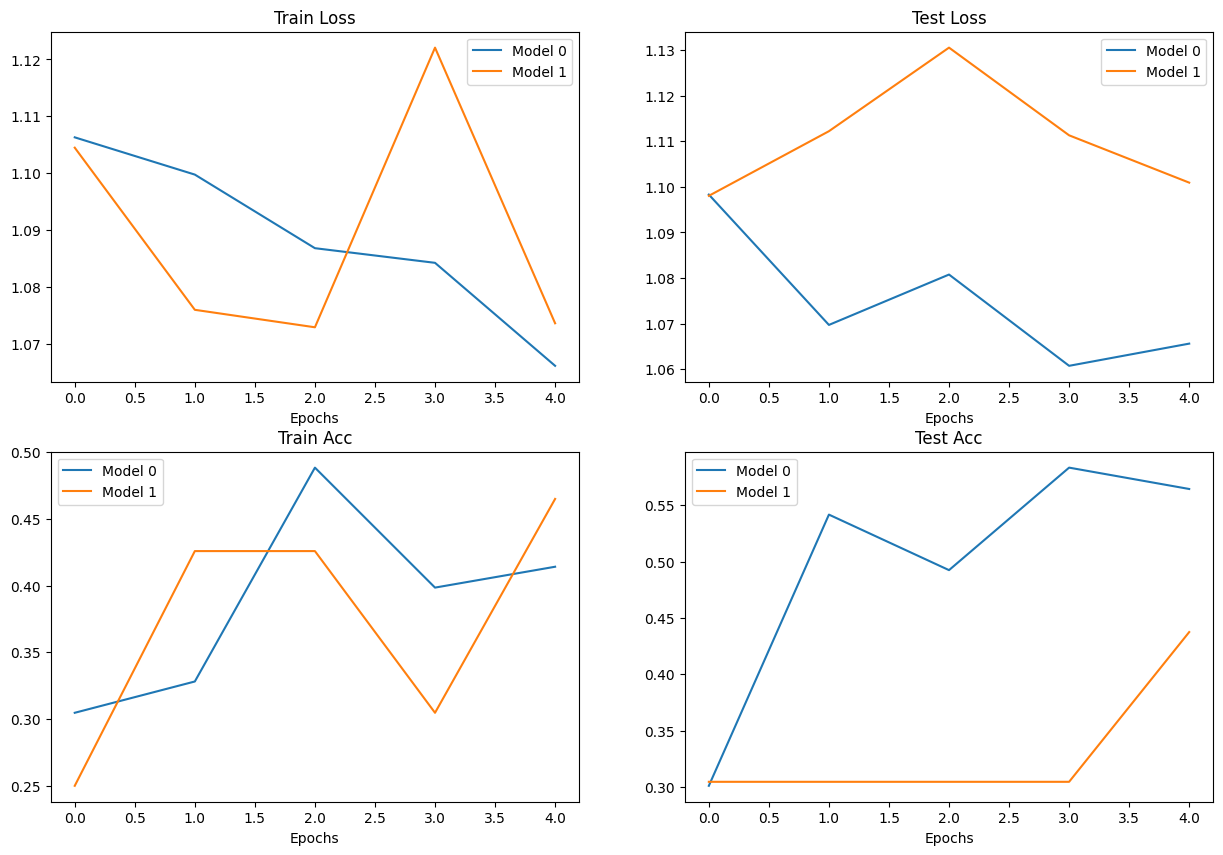

In [95]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

## 17. Predicting on custom data

### STEP 10: MAKING A PREDICTION ON A CUSTOM IMAGE

Predicting f

In [100]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


### STEP 10: LOADING A CUSTOM IMAGE WITH PyTorch

Make sure custom image is same format as model training data.
- tensor with datatype (torch.float32)
- shape 64x64x3
- correct device

In [101]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")



Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

#### 10.2 Making a prediction on custom image
Note that the sample image is still not consistent with training data
- shape is inconsistent
- datatype is inconsistent

In [109]:
# Load custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
# divide by 255

# Create a transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=None)
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Original shape: {custom_image_transformed.shape}")

# Cast the image into a batch
custom_image_transformed.unsqueeze(0)

# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))

custom_image_pred

Original shape: torch.Size([3, 4032, 3024])
Original shape: torch.Size([3, 64, 64])


tensor([[ 0.0455,  0.0591, -0.2165]])

In [110]:
# Convert logits -> prediction probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3593, 0.3642, 0.2765]])

In [112]:
# Convert prediction probs -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels
class_names[custom_image_pred_labels]

'steak'

#### 10.3 CUSTOM IMAGE PREDICTION

In [116]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names: List[str] = None,
                        transform=None):
    """Makes a prediction on a target image with a trained model"""
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    # Divide image pixel values by 255 to get them [0, 1]
    target_image = target_image / 255
    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
      target_image = target_image.unsqueeze(0)
      target_image_pred = model(target_image)

    # Convert logits -> pred probs -> pred labels
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dim and rearrange [cc,h,w]
    if class_names:
      title = f"Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
       title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max():.3f}"

    plt.title(title)
    plt.axis(False)
  

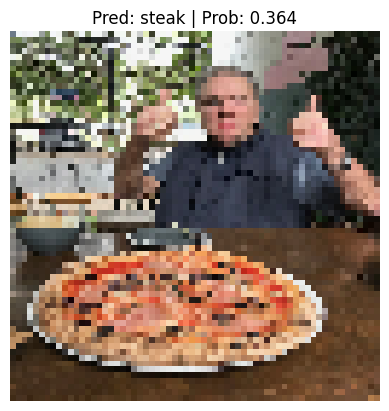

In [119]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform)

Final notes on prediction: https://youtu.be/Z_ikDlimN6A?t=91892

## Summary
- pytorch has many built-in data loading functions
- custom datasets are possible by subclassing `torch.utils.data.Dataset`
- utilize `DataLoaders` for batch processing
- Overfitting and Underfitting
- Predicting caveats
  - wrong datatypes
  - wrong data shapes
  - wrong devices